In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import SeqIO
from Bio.SeqFeature import FeatureLocation, CompoundLocation

In [2]:
folder = 'datasets/complete_and_gates'
dictionary = pd.read_csv('{}/dictionary.csv'.format(folder))
dictionary.shape

(236, 3)

In [3]:
dictionary['name'] = dictionary['name'].str.replace('*', '')

<ipython-input-3-0c469eb45658>:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  dictionary['name'] = dictionary['name'].str.replace('*', '')


In [4]:
names = dictionary['name'].tolist()

In [5]:
spacers = ['GGATCCTTA',
           'TACTAG', 'TACTAGAG',
           'ATG',
           'TAA', 'TAATAA',
           'TACTAGATG',
           'TAATACTAGAG', 'TAATACTAG',
           'TAATAATACTAGAG', 'TAATAATACTAG']

In [49]:
def generate_parts(construct):
    
    parts = []
    with open('{}.gb'.format(construct)) as input_handle:
        for record in SeqIO.parse(input_handle, 'genbank'):
            seq = record.seq
            features = record.features
            for feature in features:
                locs = feature.location
                if isinstance(locs, CompoundLocation):
                    parts.append((feature.qualifiers['label'][0], feature.type, int(feature.location.parts[0].start), int(feature.location.parts[0].end)))
                    parts.append((feature.qualifiers['label'][0], feature.type, int(feature.location.parts[1].start), int(feature.location.parts[1].end)))
                elif isinstance(locs, FeatureLocation):
                    parts.append((feature.qualifiers['label'][0], feature.type, int(feature.location.start), int(feature.location.end)))
    parts.sort(key=lambda x:x[2])
    
    return seq, parts

def remove_duplications(annotations):
    
    flag = []
    positions = np.array([[anno[2], anno[3]] for anno in annotations])
    for i in range(0, len(positions)-1):
        a, b = positions[i], positions[i+1]
        if a[1] <= b[0]:
            continue
        len_a = a[1] - a[0]
        len_b = b[1] - b[0]
        flag.append(i+1 if len_b <= len_a else i)
    
    return [annotations[i] for i in range(len(annotations)) if i not in flag]
    
def find_unannotated(seq, annotations, spacers):
    
    unannotated = []
    positions = np.array([[anno[2], anno[3]] for anno in annotations]).flatten()[1:-1]
    
    for i in range(0, len(positions)-1, 2):
        a, b = positions[i], positions[i+1]
        if a!=b and seq[a:b] not in spacers:
            unannotated.append((a, b, str(seq[a:b])))
            
    return unannotated

def vectorize(data, labels):
    
    char_to_int = dict((c, i) for i, c in enumerate(labels))
    integer_encoded = np.array([char_to_int[char] for char in data])
    onehot_encoded = list()
    for value in integer_encoded:
        letter = [0 for _ in range(len(alphabet))]
        letter[value] = 1
        onehot_encoded.append(letter)
        
    return sum(np.array(onehot_encoded))

In [20]:
collections = []
for i, name in enumerate(names):
    seq, parts = generate_parts(folder + '/' + name)
    parts = remove_duplications(parts)
    unannotated = find_unannotated(seq, parts, spacers)
    if len(unannotated) > 0:
        print(i, name)
        for unanno in unannotated:
            print(unanno)
    else:
        collections.append((name, parts))

In [21]:
len(collections)

236

In [22]:
collections[0]

('3K3-P11-gfp-B15-P(ara)-sECF11-SP1-P(Cym)-32-sM86',
 [('pSB3K3', 'backbone', 0, 140),
  ('P(11_LnE20)', 'promoter', 140, 201),
  ('RBS30', 'RBS', 209, 224),
  ('GFP', 'CDS', 230, 950),
  ('B0015', 'terminator', 958, 1087),
  ('AraC/PBAD', 'promoter', 1095, 2285),
  ('RBS33', 'RBS', 2293, 2304),
  ('ECF11_987_N-term', 'ECFs', 2310, 2652),
  ('M86_N-term.S2', 'inteins', 2652, 2961),
  ('IOT', 'terminator', 2967, 3222),
  ('CymR-AM/PCymRC', 'promoter', 3231, 4091),
  ('RiboJ', 'insulator', 4091, 4166),
  ('RBS32', 'RBS', 4174, 4187),
  ('M86_C-term.S2', 'inteins', 4196, 4367),
  ('ECF11_987_C-term', 'ECFs', 4367, 4589),
  ('ASV', 'degradation_tag', 4589, 4628),
  ('B0015.2', 'terminator', 4642, 4772),
  ('pSB3K3', 'backbone', 4772, 7304)])

In [48]:
data = ['ASV', 'B0015.2', 'ECF11_987_C-term']
print(data)

vectorization(data, labels)

['ASV', 'B0015.2', 'ECF11_987_C-term']


array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0])

In [23]:
labels = []
for col in collections:
    for anno in col[1]:
        labels.append(anno[0])
labels = list(set(labels))

In [55]:
vectorized = {}
for col in collections:
    label = [i[0] for i in col[1]][1:]
    vectorized[col[0]] = vectorize(label, labels)
vectorized

{'3K3-P11-gfp-B15-P(ara)-sECF11-SP1-P(Cym)-32-sM86': array([0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
        0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0]),
 '3K3-P11-gfp-B15-P(ara)-sECF11-SP2-P(Cym)-30-sNpuSsp.S1': array([0, 2, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
        0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0]),
 '3K3-P11-gfp-B15-P(ara)-sECF11-SP3-P(Cym)-32-sgp41-1': array([0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
        0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0

In [66]:
feat = pd.DataFrame.from_dict(vectorized, orient='index', columns=labels).reset_index()
feat

,index,ECF33_423_N-term,RBS30,ASV,ECF41_491_C-term,IOT,ECF16_3622_N-term,P(20_T5Ln17),TerThyX_N-term.S1,P(26_up601),...,ECF32_1122_N-term,SspGyrB_N-term.S2,Mja-KlbA_C-term.S2,TvoVMA_N-term.SX,Translation 4121-4237,ECF34_1384_C-term,PhoRadA_C-term.S2,ECF42_4454_C-term,TerThyX_C-term.S1,ECF38_1322_C-term
0,3K3-P11-gfp-B15-P(ara)-sECF11-SP1-P(Cym)-32-sM86,0,1,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3K3-P11-gfp-B15-P(ara)-sECF11-SP2-P(Cym)-30-sN...,0,2,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3K3-P11-gfp-B15-P(ara)-sECF11-SP3-P(Cym)-32-sg...,0,1,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3K3-P11-gfp-B15-P(ara)-sECF11-SP4-P(Cym)-30-sg...,0,2,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3K3-P11-gfp-B15-P(ara)-sECF11-SP4-P(Cym)-32-sg...,0,1,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231,3K3-P42-gfp-B15-P(ara)-sECF42-SP11-P(Cym)-30-(...,0,2,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
232,3K3-P42-gfp-B15-P(ara)-sECF42-SP11-P(Cym)-32-(...,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
233,3K3-P42-gfp-B15-P(ara)-sECF42-SP29-P(Cym)-30-s...,0,2,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
234,3K3-P42-gfp-B15-P(ara)-sECF42-SP31-P(Cym)-32-s...,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


Import label

In [60]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, r2_score
from sklearn.svm import SVR

In [67]:
df = pd.merge(dictionary, feat, left_on='name', right_on='index', how='inner').drop(['name', 'construct_id', 'index'], axis=1)
df

,short_name,ECF33_423_N-term,RBS30,ASV,ECF41_491_C-term,IOT,ECF16_3622_N-term,P(20_T5Ln17),TerThyX_N-term.S1,P(26_up601),...,ECF32_1122_N-term,SspGyrB_N-term.S2,Mja-KlbA_C-term.S2,TvoVMA_N-term.SX,Translation 4121-4237,ECF34_1384_C-term,PhoRadA_C-term.S2,ECF42_4454_C-term,TerThyX_C-term.S1,ECF38_1322_C-term
0,e11x32M86,0,1,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,e11x30NpuSspS1,0,2,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,e11x32gp411,0,1,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,e11x30gp418,0,2,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,e11x32gp418,0,1,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231,e42x30STPhoRadA,0,2,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
232,e42x32STPhoRadA,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
233,e42x30SaPdpol,0,2,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
234,e42x32NrdA2,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [72]:
target = pd.read_csv('{}/{}'.format(folder, 'fluo.csv')).T.reset_index()
target.columns = ['short_name', 'ON', 'OFF', 'DR']
target

,short_name,ON,OFF,DR
0,e11x32gp411,2.404721,0.004515,532.561404
1,e11x32STPhoRadA,1.425120,0.001426,999.444444
2,e11x32NrdJ1,5.483107,0.000317,17304.000000
3,e11x32NrdA2,3.166000,0.003644,868.826087
4,e11x32CthTer,0.048719,-0.001109,43.928571
...,...,...,...,...
140,e38x32CthTer,0.382489,0.008817,43.381944
141,e41x32gp418,0.020144,0.006368,3.163462
142,e42x33NrdA2,0.007592,0.000551,13.777778
143,e42x30SaPdpol,-0.000429,0.002082,0.205882


In [77]:
X1 = pd.merge(target, df, on='short_name', how='inner')
X = X1.drop(['short_name', 'ON', 'OFF', 'DR'], axis=1).values
y = X1['ON'].values

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10)
print(X_train.shape, X_test.shape)
RF_model = RandomForestRegressor(n_estimators=100)
RF_model.fit(X_train, y_train)

(126, 93) (15, 93)


RandomForestRegressor()

In [96]:
y_pred = RF_model.predict(X_test)
r2_score(y_test, y_pred)

0.4650278036589788

/Users/mardian/Documents/Edinburgh/Notebook/env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


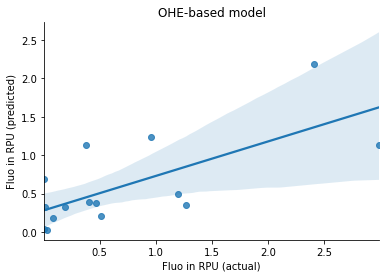

In [102]:
sns.regplot(y_test, y_pred)
plt.xlabel('Fluo in RPU (actual)')
plt.ylabel('Fluo in RPU (predicted)')
plt.title('OHE-based model')
sns.despine()